<a href="https://colab.research.google.com/github/Owais-cmd/AIML-project-/blob/main/aiml_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:215: SyntaxWarning: invalid escape sequence '\s'
<>:215: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3871774324.py:215: SyntaxWarning: invalid escape sequence '\s'
  plt.suptitle(f"Robustness Test: Model Trained on $\sigma=0.05$", fontsize=16)


Running on: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]



Training with Adam (Sigma=0.05) for 10 Epochs...


Epoch 1 [Train]: 100%|██████████| 2813/2813 [01:57<00:00, 23.95it/s]


Loss -> Train: 0.00500 | Val: 0.00144 | Test: 0.00144


Epoch 2 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.37it/s]


Loss -> Train: 0.00321 | Val: 0.00172 | Test: 0.00172


Epoch 3 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.38it/s]


Loss -> Train: 0.00261 | Val: 0.00141 | Test: 0.00140


Epoch 4 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.41it/s]


Loss -> Train: 0.00229 | Val: 0.00115 | Test: 0.00114


Epoch 5 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.32it/s]


Loss -> Train: 0.00204 | Val: 0.00146 | Test: 0.00145


Epoch 6 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.28it/s]


Loss -> Train: 0.00185 | Val: 0.00141 | Test: 0.00140


Epoch 7 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.32it/s]


Loss -> Train: 0.00174 | Val: 0.00163 | Test: 0.00163


Epoch 8 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.33it/s]


Loss -> Train: 0.00165 | Val: 0.00136 | Test: 0.00137


Epoch 9 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.32it/s]


Loss -> Train: 0.00160 | Val: 0.00168 | Test: 0.00168


Epoch 10 [Train]: 100%|██████████| 2813/2813 [01:55<00:00, 24.29it/s]


Loss -> Train: 0.00153 | Val: 0.00133 | Test: 0.00133


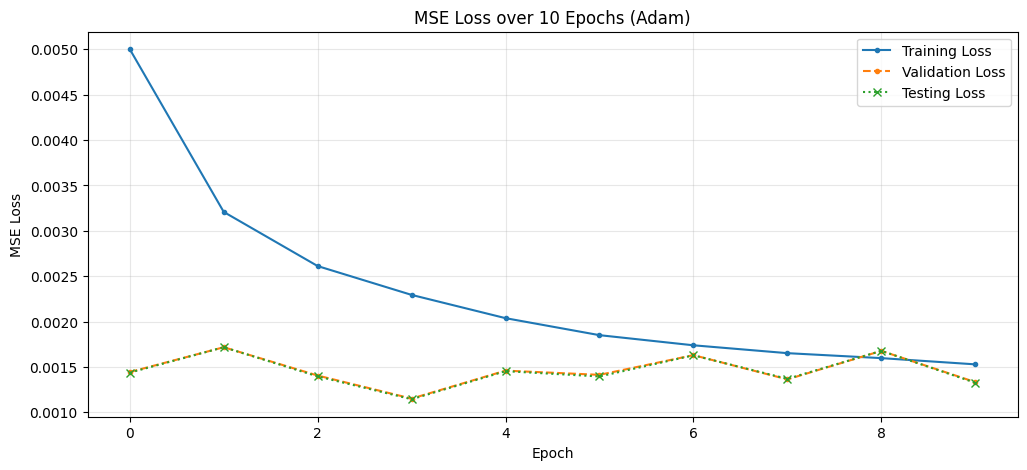


Generating Final Comparison Grid...


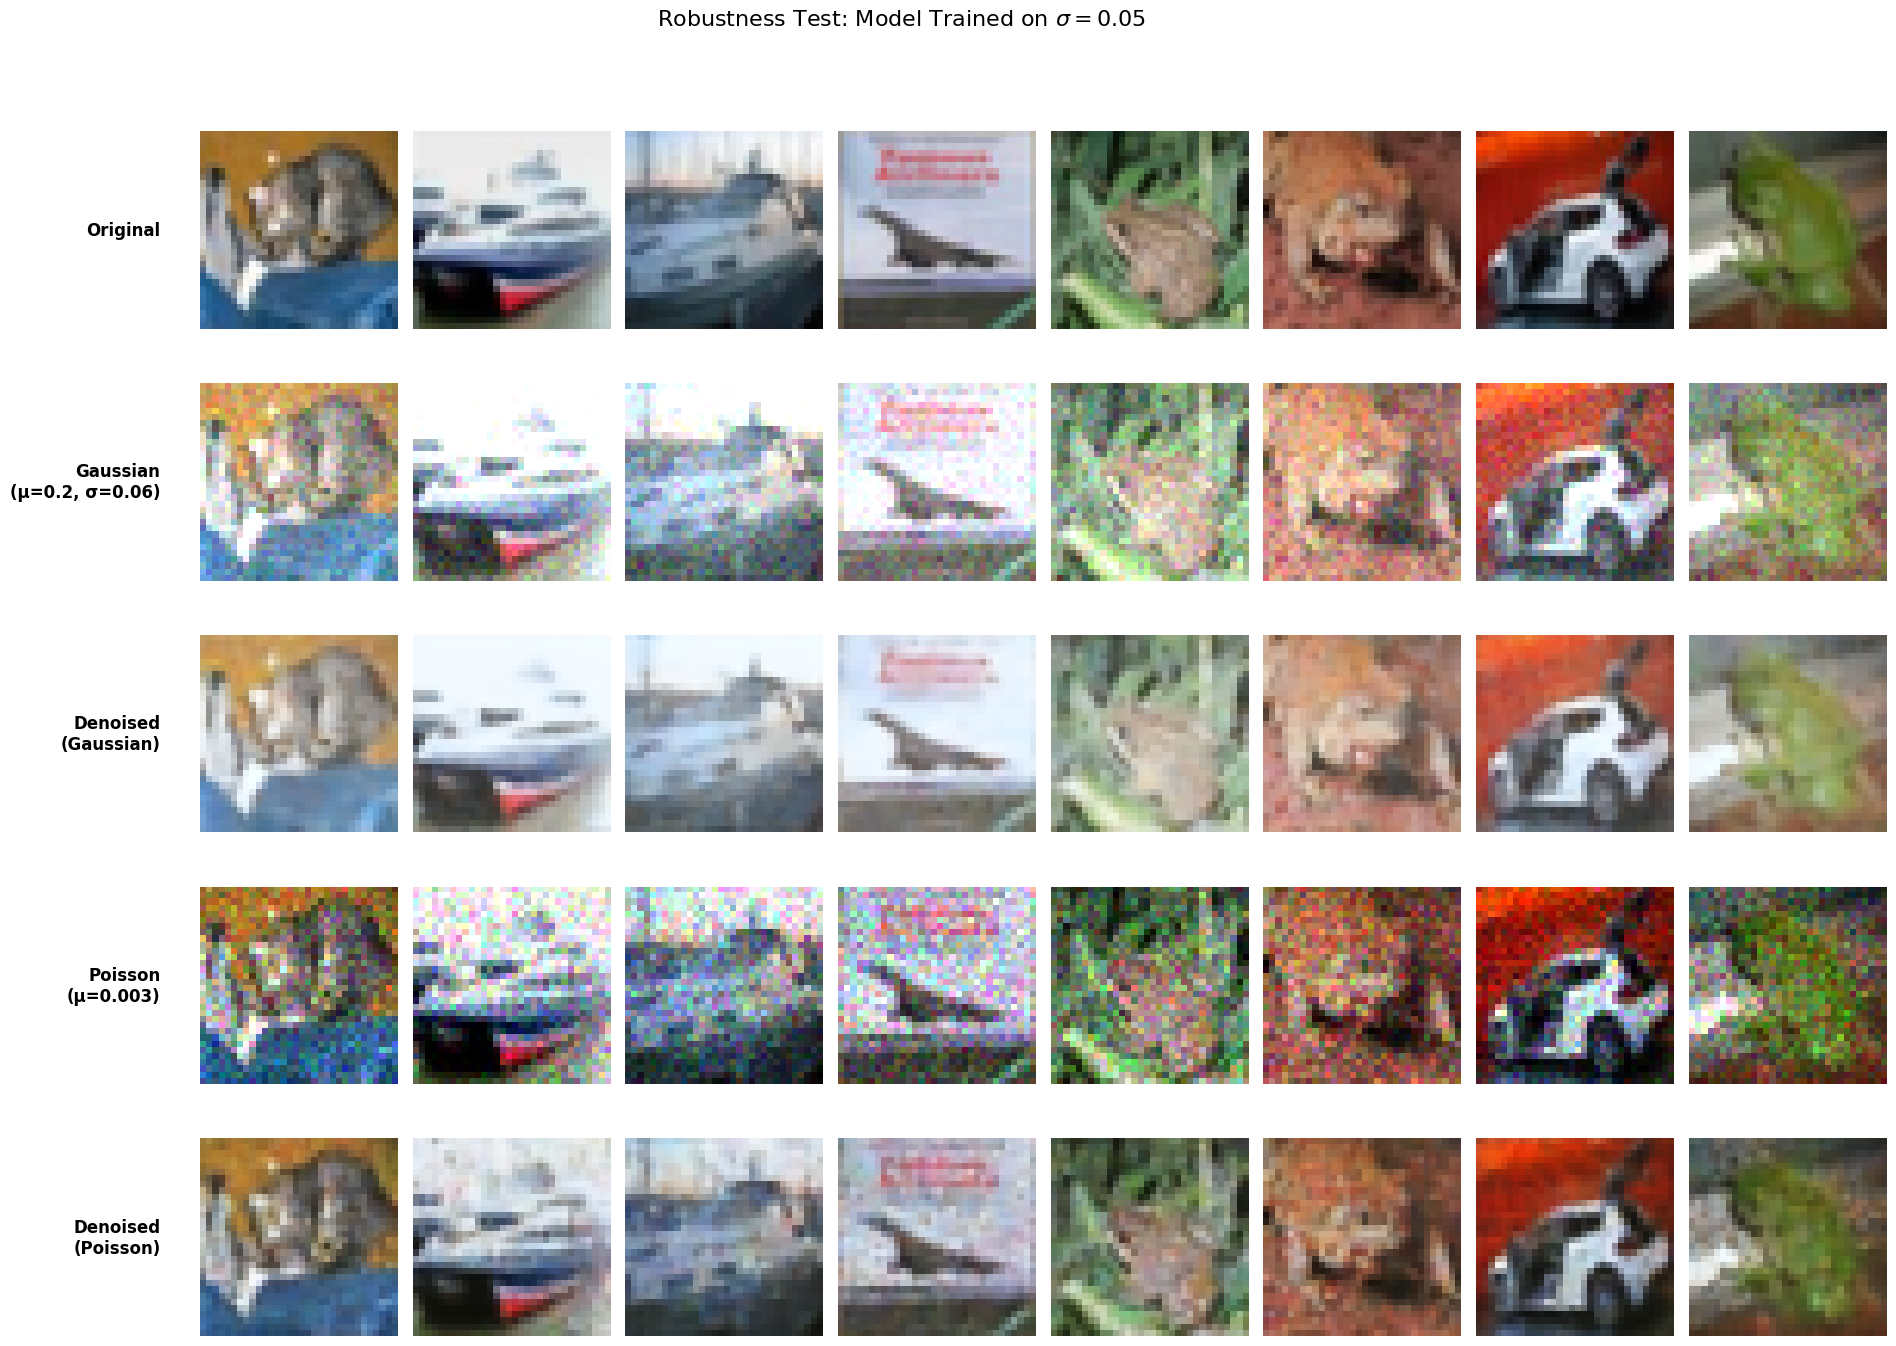

In [1]:
# U-Net Image Denoising - Adam (10 Epochs) + Test Loss Plot
# Run in Google Colab with GPU

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================
# 1. Configuration
# ============================================
CONF = {
    'EPOCHS': 10,
    'BATCH_SIZE': 16,
    'LR': 0.001,
    'TRAIN_SIGMA': 0.05,     # Training noise level
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu'
}
print(f"Running on: {CONF['DEVICE']}")

# ============================================
# 2. U-Net Architecture
# ============================================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, dropout_rate=0.2):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64, dropout_rate)
        self.enc2 = DoubleConv(64, 128, dropout_rate)
        self.enc3 = DoubleConv(128, 256, dropout_rate)
        self.enc4 = DoubleConv(256, 512, dropout_rate)
        self.bottleneck = DoubleConv(512, 1024, dropout_rate)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512, dropout_rate)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256, dropout_rate)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128, dropout_rate)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64, dropout_rate)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return self.out_conv(d1)

# ============================================
# 3. Noise Functions
# ============================================
def add_training_noise(images, sigma=0.05):
    """Standard noise for training"""
    noise = torch.randn_like(images) * sigma
    return torch.clamp(images + noise, 0.0, 1.0)

def add_specific_gaussian(images, mean=0.2, sigma=0.06):
    """Requested Test: Gaussian Mean=0.2, Sigma=0.06"""
    noise = (torch.randn_like(images) * sigma) + mean
    return torch.clamp(images + noise, 0.0, 1.0)

def add_specific_poisson(images, mean=0.003):
    """Requested Test: Poisson (Mean ~0.003)"""
    noise = torch.poisson(images * 50.0) / 50.0
    noise_overlay = (noise - images) + 0.003
    return torch.clamp(images + noise_overlay, 0.0, 1.0)

# ============================================
# 4. Training & Testing Logic
# ============================================
def run_full_pipeline():
    # --- Data Loading ---
    transform = transforms.Compose([transforms.ToTensor()])

    # Training Set (Split into Train 45k / Val 5k)
    dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_data, val_data = random_split(dataset_train, [45000, 5000])

    # Test Set (10k)
    dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=CONF['BATCH_SIZE'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=CONF['BATCH_SIZE'], shuffle=False)
    # We use the full test set for loss calculation
    test_loader_full = DataLoader(dataset_test, batch_size=CONF['BATCH_SIZE'], shuffle=False)

    # --- Model Setup ---
    model = UNet().to(CONF['DEVICE'])
    optimizer = optim.Adam(model.parameters(), lr=CONF['LR'])
    criterion = nn.MSELoss()

    history = {'train': [], 'val': [], 'test': []}

    print(f"\nTraining with Adam (Sigma={CONF['TRAIN_SIGMA']}) for {CONF['EPOCHS']} Epochs...")

    for epoch in range(CONF['EPOCHS']):
        # 1. Training Loop
        model.train()
        train_loss = 0
        for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            imgs = imgs.to(CONF['DEVICE'])
            noisy = add_training_noise(imgs, CONF['TRAIN_SIGMA'])

            optimizer.zero_grad()
            output = model(noisy)
            loss = criterion(output, imgs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # 2. Validation Loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, _ in val_loader:
                imgs = imgs.to(CONF['DEVICE'])
                noisy = add_training_noise(imgs, CONF['TRAIN_SIGMA'])
                output = model(noisy)
                val_loss += criterion(output, imgs).item()

        # 3. Testing Loop (New)
        test_loss = 0
        with torch.no_grad():
            for imgs, _ in test_loader_full:
                imgs = imgs.to(CONF['DEVICE'])
                # For testing loss, we use the same standard noise to see how it generalizes
                noisy = add_training_noise(imgs, CONF['TRAIN_SIGMA'])
                output = model(noisy)
                test_loss += criterion(output, imgs).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        avg_test = test_loss / len(test_loader_full)

        history['train'].append(avg_train)
        history['val'].append(avg_val)
        history['test'].append(avg_test)

        print(f"Loss -> Train: {avg_train:.5f} | Val: {avg_val:.5f} | Test: {avg_test:.5f}")

    # --- Plotting All 3 Losses ---
    plt.figure(figsize=(12, 5))
    plt.plot(history['train'], label='Training Loss', linestyle='-', marker='.')
    plt.plot(history['val'], label='Validation Loss', linestyle='--', marker='.')
    plt.plot(history['test'], label='Testing Loss', linestyle=':', marker='x')
    plt.title(f"MSE Loss over {CONF['EPOCHS']} Epochs (Adam)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- Final Visualization (The 8 Images Grid) ---
    print("\nGenerating Final Comparison Grid...")
    visualize_final_grid(model, test_loader_full)

def visualize_final_grid(model, loader):
    model.eval()
    # Get first batch for visualization
    images, _ = next(iter(loader))
    images = images[:8].to(CONF['DEVICE'])

    # 1. Generate specific noise types
    noisy_gauss = add_specific_gaussian(images, mean=0.2, sigma=0.06)
    noisy_poiss = add_specific_poisson(images, mean=0.003)

    # 2. Denoise
    with torch.no_grad():
        denoised_gauss = model(noisy_gauss)
        denoised_poiss = model(noisy_poiss)

        denoised_gauss = torch.clamp(denoised_gauss, 0, 1)
        denoised_poiss = torch.clamp(denoised_poiss, 0, 1)

    images = images.cpu()
    noisy_gauss = noisy_gauss.cpu()
    denoised_gauss = denoised_gauss.cpu()
    noisy_poiss = noisy_poiss.cpu()
    denoised_poiss = denoised_poiss.cpu()

    # 3. Plot 5 Rows x 8 Columns
    fig, axs = plt.subplots(5, 8, figsize=(20, 14))
    plt.suptitle(f"Robustness Test: Model Trained on $\sigma=0.05$", fontsize=16)

    rows = [
        ("Original", images),
        ("Gaussian\n(μ=0.2, σ=0.06)", noisy_gauss),
        ("Denoised\n(Gaussian)", denoised_gauss),
        ("Poisson\n(μ=0.003)", noisy_poiss),
        ("Denoised\n(Poisson)", denoised_poiss)
    ]

    for row_idx, (label, data) in enumerate(rows):
        for col_idx in range(8):
            ax = axs[row_idx, col_idx]
            ax.imshow(data[col_idx].permute(1, 2, 0))
            ax.axis('off')
            if col_idx == 0:
                ax.text(-0.2, 0.5, label, transform=ax.transAxes,
                        fontsize=12, va='center', ha='right', fontweight='bold')

    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    run_full_pipeline()

In [4]:
# ==========================================
# RUN THIS IN A NEW CELL
# ==========================================

# 1. Check if model exists, if not, try to load it or warn user
try:
    # Try to use the local model if it was returned or is global
    # If you named it 'model' inside a function, it might not be here.
    # But if you just ran the code, let's assume we can access the class UNet.
    pass
except NameError:
    print("Error: Model not found. If you ran the training inside a function, the model variable is lost.")

# 2. Re-instantiate test loader (Fast)
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader_metrics = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3. Define the metric calculation
def calculate_metrics_now(net):
    net.eval()
    psnr_gauss_list = []
    psnr_poiss_list = []

    print("\nCalculating metrics on full test set (10k images)...")

    with torch.no_grad():
        for images, _ in tqdm(test_loader_metrics, desc="Processing"):
            images = images.to(CONF['DEVICE'])

            # Gaussian (Mean=0.2, Sigma=0.06)
            noisy_g = add_specific_gaussian(images, mean=0.2, sigma=0.06)
            denoised_g = torch.clamp(net(noisy_g), 0, 1)

            # Poisson (Mean=0.003)
            noisy_p = add_specific_poisson(images, mean=0.003)
            denoised_p = torch.clamp(net(noisy_p), 0, 1)

            # PSNR
            for i in range(images.size(0)):
                # Manual PSNR calc to ensure standalone functionality
                mse_g = torch.mean((images[i] - denoised_g[i]) ** 2)
                psnr_g = 20 * torch.log10(1.0 / torch.sqrt(mse_g)).item()
                psnr_gauss_list.append(psnr_g)

                mse_p = torch.mean((images[i] - denoised_p[i]) ** 2)
                psnr_p = 20 * torch.log10(1.0 / torch.sqrt(mse_p)).item()
                psnr_poiss_list.append(psnr_p)

    print(f"\nGaussian Noise (μ=0.2, σ=0.06) Average PSNR: {np.mean(psnr_gauss_list):.2f} dB")
    print(f"Poisson Noise  (μ=0.003)       Average PSNR: {np.mean(psnr_poiss_list):.2f} dB")

# 4. EXECUTE
# We need to find the model object.
# If you followed my previous code exactly, the model was inside 'run_pipeline'.
# BUT, python functions in notebooks often leak variables or you might have modified it.
# IF NOT, you have to re-run the training ONCE with 'return model' at the end.

# TRYING TO FIND THE MODEL AUTOMATICALLY:
import gc
found_model = None
for obj in gc.get_objects():
    if isinstance(obj, UNet):
        found_model = obj
        break

if found_model:
    print("Found the trained model in memory!")
    calculate_metrics_now(found_model)
else:
    print("Could not find the trained model in memory.")
    print("Please go to your training cell, add 'return model' at the end, and run: model = run_pipeline()")

/tmp/ipython-input-2398592306.py:63: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if isinstance(obj, UNet):


Found the trained model in memory!

Calculating metrics on full test set (10k images)...


Processing: 100%|██████████| 625/625 [00:17<00:00, 35.01it/s]


Gaussian Noise (μ=0.2, σ=0.06) Average PSNR: 14.80 dB
Poisson Noise  (μ=0.003)       Average PSNR: 25.88 dB


In [5]:
# =================================================================
# RUN THIS IN A NEW CELL
# 1. Detailed Metrics (Noisy vs Denoised)
# 2. Save Model
# =================================================================

import torch
import numpy as np
from tqdm import tqdm
from google.colab import files  # To download the saved model

# --- 1. helper to find the model if variable name is lost ---
import gc
final_model = None

# Try to find 'found_model' from previous cell, or 'model', or 'trained_model'
if 'found_model' in locals():
    final_model = found_model
elif 'model' in locals():
    final_model = model
elif 'trained_model' in locals():
    final_model = trained_model
else:
    # Last resort: Search memory for the UNet class
    print("Searching memory for model...")
    for obj in gc.get_objects():
        if isinstance(obj, UNet):
            final_model = obj
            break

if final_model is None:
    raise ValueError("Could not find the trained model in memory. You might need to re-run training.")

print("Model found! Proceeding with calculations...\n")

# --- 2. Metric Calculation ---
def calculate_detailed_metrics(net, loader):
    net.eval()

    # Store results
    results = {
        'gauss': {'noisy': [], 'denoised': []},
        'poiss': {'noisy': [], 'denoised': []}
    }

    def get_psnr(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        if mse == 0: return float('inf')
        return 20 * torch.log10(1.0 / torch.sqrt(mse)).item()

    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Calculating Metrics"):
            images = images.to(CONF['DEVICE'])

            # --- A. Gaussian (μ=0.2, σ=0.06) ---
            noisy_g = add_specific_gaussian(images, mean=0.2, sigma=0.06)
            denoised_g = torch.clamp(net(noisy_g), 0, 1)

            # --- B. Poisson (μ=0.003) ---
            noisy_p = add_specific_poisson(images, mean=0.003)
            denoised_p = torch.clamp(net(noisy_p), 0, 1)

            # Calculate PSNRs per image
            for i in range(images.size(0)):
                # Gaussian
                results['gauss']['noisy'].append(get_psnr(images[i], noisy_g[i]))
                results['gauss']['denoised'].append(get_psnr(images[i], denoised_g[i]))

                # Poisson
                results['poiss']['noisy'].append(get_psnr(images[i], noisy_p[i]))
                results['poiss']['denoised'].append(get_psnr(images[i], denoised_p[i]))

    # --- Print Summary ---
    print("\n" + "="*60)
    print("FINAL DETAILED RESULTS (Average PSNR)")
    print("="*60)

    g_noisy_avg = np.mean(results['gauss']['noisy'])
    g_denoised_avg = np.mean(results['gauss']['denoised'])
    g_gain = g_denoised_avg - g_noisy_avg

    p_noisy_avg = np.mean(results['poiss']['noisy'])
    p_denoised_avg = np.mean(results['poiss']['denoised'])
    p_gain = p_denoised_avg - p_noisy_avg

    print(f"1. Gaussian Noise (Mean=0.2, Sigma=0.06)")
    print(f"   - Average Noisy PSNR:    {g_noisy_avg:.2f} dB")
    print(f"   - Average Denoised PSNR: {g_denoised_avg:.2f} dB")
    print(f"   - Improvement:           +{g_gain:.2f} dB")
    print("-" * 60)
    print(f"2. Poisson Noise (Mean ~0.003)")
    print(f"   - Average Noisy PSNR:    {p_noisy_avg:.2f} dB")
    print(f"   - Average Denoised PSNR: {p_denoised_avg:.2f} dB")
    print(f"   - Improvement:           +{p_gain:.2f} dB")
    print("="*60)

# Run Calculation
# Re-create loader just to be safe
test_loader_final = DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()),
                             batch_size=16, shuffle=False)
calculate_detailed_metrics(final_model, test_loader_final)

# --- 3. Save Model ---
print("\nSaving model to 'unet_denoising_model.pth'...")
torch.save(final_model.state_dict(), 'unet_denoising_model.pth')
print("Model saved locally.")

try:
    print("Attempting to download file to your computer...")
    files.download('unet_denoising_model.pth')
except Exception as e:
    print("Could not automatically download. You can find the file in the 'Files' tab on the left.")

Model found! Proceeding with calculations...



Calculating Metrics: 100%|██████████| 625/625 [00:20<00:00, 30.61it/s]



FINAL DETAILED RESULTS (Average PSNR)
1. Gaussian Noise (Mean=0.2, Sigma=0.06)
   - Average Noisy PSNR:    14.13 dB
   - Average Denoised PSNR: 14.80 dB
   - Improvement:           +0.67 dB
------------------------------------------------------------
2. Poisson Noise (Mean ~0.003)
   - Average Noisy PSNR:    20.75 dB
   - Average Denoised PSNR: 25.87 dB
   - Improvement:           +5.12 dB

Saving model to 'unet_denoising_model.pth'...
Model saved locally.
Attempting to download file to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>